# Run batches of FastScape simulations

Via xarray-simlab, we leverage the ``dask`` library (https://docs.dask.org/en/latest/) and its integration with ``xarray`` to easily run, analyse and visualize batches of model runs, e.g., in the cases of sentitivity analyses or inversions.

Let's import some packages first:

In [1]:
import numpy as np
import xarray as xr
import xsimlab as xs
import fastscape

In [2]:
print('xarray-simlab version: ', xs.__version__)
print('fastscape version: ', fastscape.__version__)

xarray-simlab version:  0.4.1
fastscape version:  0.1.0beta


You won't need to run the cell below when support for running batches of simulations will be added in ``xarray-simlab``.

## Import the model and the model base setup

Let's import the basic (standard) FastScape model

In [3]:
from fastscape.models import basic_model

The setup create in the ``run_basic_model`` is reused here as a base setup

In [4]:
in_ds = xr.load_dataset('basic_input.nc')

## Example 1: run models for different values of $K$ (stream power law)

We just need to set the corresponding variable with different values and a dimension label for the batch, and then pass this dimension label to ``.xsimlab.run``. To run the models in parallel we set ``parallel=True`` and we choose here Dask's ``processes`` scheduler. With this scheduler, we also need to set ``store`` with a compatible storage alternative (i.e., not the default, in-memory store).

In [23]:
in_vars = {'spl__k_coef': ('spl__k_coef', np.linspace(1e-5, 1e-4, 20))}

In [25]:
from dask.diagnostics import ProgressBar

with basic_model, ProgressBar():
    out_ds = (
        in_ds
        .xsimlab.update_vars(input_vars=in_vars)
        .xsimlab.run(batch_dim='spl__k_coef', parallel=True, scheduler="processes", store="batch.zarr")
    )
    
out_ds

[########################################] | 100% Completed |  4.3s


<xarray.Dataset>
Dimensions:                 (border: 4, out: 11, shape_yx: 2, spl__k_coef: 20, time: 101, x: 201, y: 101)
Coordinates:
  * border                  (border) <U6 'left' 'right' 'top' 'bottom'
  * out                     (out) float64 0.0 1e+05 2e+05 ... 8e+05 9e+05 1e+06
  * spl__k_coef             (spl__k_coef) float64 1e-05 1.474e-05 ... 0.0001
  * time                    (time) float64 0.0 1e+04 2e+04 ... 9.9e+05 1e+06
  * x                       (x) float64 0.0 100.0 200.0 ... 1.99e+04 2e+04
  * y                       (y) float64 0.0 100.0 200.0 ... 9.9e+03 1e+04
Dimensions without coordinates: shape_yx
Data variables:
    boundary__status        (border) object dask.array<chunksize=(4,), meta=np.ndarray>
    diffusion__diffusivity  float64 0.1
    drainage__area          (spl__k_coef, out, y, x) float64 dask.array<chunksize=(1, 6, 51, 101), meta=np.ndarray>
    flow__basin             (spl__k_coef, out, y, x) int64 dask.array<chunksize=(1, 6, 51, 101), meta=np.ndar

Plotting using ``hvplot`` is just as easy as with single model runs. We can easily explore the parameter space.

In [26]:
import hvplot.xarray
import matplotlib.pyplot as plt

out_ds.topography__elevation.hvplot.image(
    x='x', y='y', cmap=plt.cm.viridis, groupby=['spl__k_coef', 'out'])

:DynamicMap   [spl__k_coef,out]
   :Image   [x,y]   (topography__elevation)

Extracting statistics along the batch dimension is very easy (and it's executed in parallel):

In [29]:
avg = out_ds.topography__elevation.mean(dim='spl__k_coef')


Selecting and plotting cross-sections is easy too:

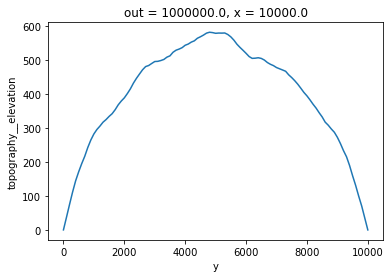

In [30]:
avg.isel(out=-1).sel(x=10000).plot();

Xarray has powerful plotting capabilities implemented on top of matplotlib:

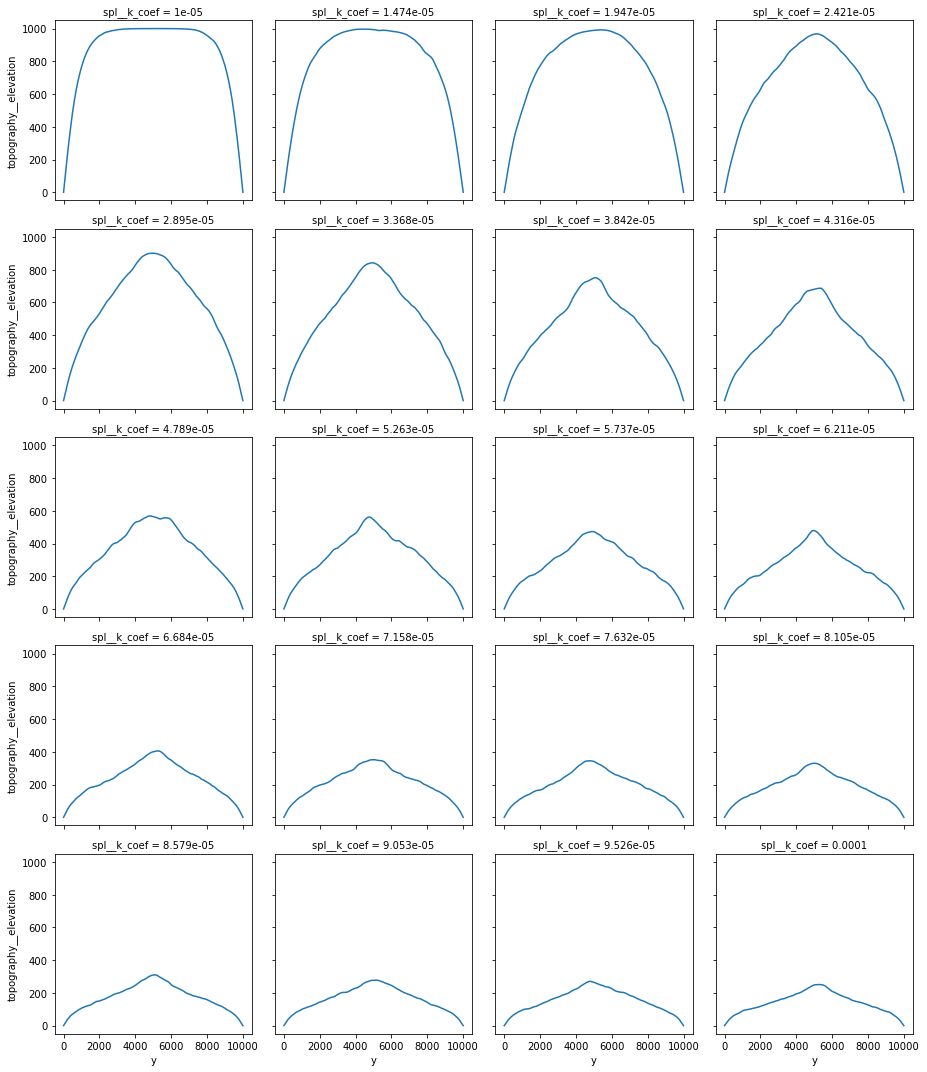

In [40]:
(out_ds
 .topography__elevation.isel(out=-1)            # select elevation at the end of the simulation
 .mean(dim='x')                                 # average over the 'x' axis
 .plot(col='spl__k_coef', col_wrap=4)           # plot for all simulations in the batch (K coef values)
);      